In [1]:
import pandas as pd
import numpy as np

def estimate_irradiance_kwh(timestamp: pd.Timestamp, humidity_pct: float, latitude: float) -> float:
    """
    Approximate hourly surface irradiance (kWh/m²) by:
      1) computing extraterrestrial normal irradiance (G_on),
      2) projecting it to horizontal (G0h = G_on * sin(solar_elevation)),
      3) applying a simple clearness index based on humidity (Kt = 1 − humidity_pct/100),
      4) converting W/m² → kWh/m² for one hour.

    Returns 0.0000 if the sun is below the horizon.
    """
    n = timestamp.timetuple().tm_yday
    hour_decimal = timestamp.hour + timestamp.minute / 60.0
    omega = (np.pi / 12.0) * (hour_decimal - 12.0)
    delta = 0.409 * np.sin((2 * np.pi / 365) * n - 1.39)
    phi = np.radians(latitude)

    beta = np.arcsin(
        np.sin(phi) * np.sin(delta) +
        np.cos(phi) * np.cos(delta) * np.cos(omega)
    )
    if beta <= 0.0:
        return 0.0

    E0 = 1.0 + 0.033 * np.cos((2 * np.pi / 365) * n)
    G_sc = 1367.0  # W/m²
    G_on = G_sc * E0
    G0h = G_on * np.sin(beta)  # W/m²

    Kt = max(0.0, min(1.0 - (humidity_pct / 100.0), 1.0))
    Gh = Kt * G0h
    return round(Gh / 1000.0, 4)  # kWh/m²


# --------------------------- Script Starts Here ---------------------------

# Step 0: Load processed weather CSV with 'Humidity_%' column
input_path = "Data/Exp/ProcessedData_Wollongong_Weather__10_20_Jan_2025.csv"
df = pd.read_csv(input_path, parse_dates=['Timestamp'])

# Define severe‐weather window
SEVERE_START = pd.Timestamp("2025-01-15 4:20")
SEVERE_END   = pd.Timestamp("2025-01-18 22:59")

# Step 1: Compute clear‐sky irradiance
latitude = -34.416  # Wollongong latitude
df['Irradiance_kW/m2'] = df.apply(
    lambda row: estimate_irradiance_kwh(
        timestamp=row['Timestamp'],
        humidity_pct=row['Humidity_%'],
        latitude=latitude
    ),
    axis=1
)

# Step 2: Define pre/during/post masks
mask_pre    = df['Timestamp'] < SEVERE_START
mask_severe = (df['Timestamp'] >= SEVERE_START) & (df['Timestamp'] <= SEVERE_END)
mask_post   = df['Timestamp'] > SEVERE_END

# Step 3: Choose reduction factors
FACTOR_PRE    = 1.1   # 80% of clear-sky before the storm
FACTOR_SEVERE = 0.15   # 10% during the storm
FACTOR_POST   = 0.4   # 90% of clear-sky after the storm

# Step 4: Apply multiplication factors
df.loc[mask_pre,    'Irradiance_kW/m2'] *= FACTOR_PRE
df.loc[mask_severe, 'Irradiance_kW/m2'] *= FACTOR_SEVERE
df.loc[mask_post,   'Irradiance_kW/m2'] *= FACTOR_POST

# Step 5: (Optional) Round the adjusted column to 4 decimals
df['Irradiance_kW/m2'] = df['Irradiance_kW/m2'].round(4)


In [2]:
df.describe()

,Timestamp,Temperature_C,Wind_km_h,Humidity_%,Precipitation_%,Irradiance_kW/m2
count,255,255.000000,255.000000,255.000000,255.000000,255.000000
mean,2025-01-15 10:17:52.941176320,21.576471,23.835294,80.650980,19.707765,0.061058
min,2025-01-10 00:00:00,16.000000,0.000000,53.000000,0.000000,0.000000
25%,2025-01-12 15:30:00,20.000000,11.000000,73.000000,2.195000,0.000000
50%,2025-01-15 08:00:00,22.000000,17.000000,83.000000,10.470000,0.015200
75%,2025-01-18 07:30:00,23.000000,37.000000,90.500000,36.165000,0.094150
max,2025-01-20 23:00:00,26.000000,76.000000,96.000000,97.000000,0.393700
std,NaN,2.173805,18.078469,11.672354,22.680716,0.091933


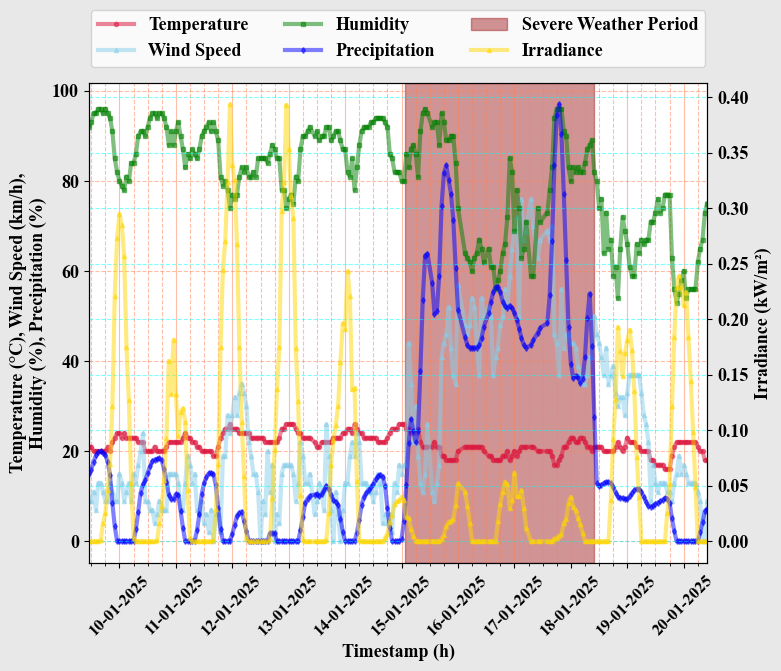

In [3]:
"""
Wollongong Weather (10–20 Jan 2025) — Multi-variable Time-Series Plot
--------------------------------------------------------------------
This script produces a publication-quality PNG visualizing five
meteorological variables (temperature, wind speed, humidity,
precipitation, irradiance) recorded in Wollongong, NSW.

* Primaries (left y-axis): Temperature, Wind Speed, Humidity, Precipitation
* Secondary (right y-axis): Irradiance
* Extras: 6-hour grid, shaded severe-weather window, combined legend,
          transparent gray canvas for print readability
"""

# ------------------------------------------------------------------
# 0. Imports & Global Matplotlib Style
# ------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import to_rgba   # handy RGBA helper

plt.rcParams.update({                   # global style: Times, bold
    "font.family": "Times New Roman",
    "font.size"  : 13,
    "font.weight": "bold",
})

# ------------------------------------------------------------------
# 1. Figure & Primary Axes
# ------------------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(8, 7))     # square-ish aspect

# ------------------------------------------------------------------
# 2. Plot Four Variables on the Primary y-axis
# ------------------------------------------------------------------
ax1.plot(df['Timestamp'], df['Temperature_C'],
         label='Temperature',
         color='crimson', linewidth=3,
         marker='o', markersize=3, alpha=0.50)

ax1.plot(df['Timestamp'], df['Wind_km_h'],
         label='Wind Speed',
         color='skyblue', linewidth=3,
         marker='^', markersize=3, alpha=0.50)

ax1.plot(df['Timestamp'], df['Humidity_%'],
         label='Humidity',
         color='green', linewidth=3,
         marker='s', markersize=3, alpha=0.50)

ax1.plot(df['Timestamp'], df['Precipitation_%'],
         label='Precipitation',
         color='blue', linewidth=3,
         marker='d', markersize=3, alpha=0.50)

# ------------------------------------------------------------------
# 3. Secondary Axes for Irradiance
# ------------------------------------------------------------------
ax2 = ax1.twinx()                        # shares the same x-axis
ax2.plot(df['Timestamp'], df['Irradiance_kW/m2'],
         label='Irradiance',
         color='gold', linewidth=3,
         marker='^', markersize=3, alpha=0.50)

# ------------------------------------------------------------------
# 4. Axis Labels
# ------------------------------------------------------------------
ax1.set_xlabel('Timestamp (h)', fontweight='bold')
ax1.set_ylabel('Temperature (°C), Wind Speed (km/h),\nHumidity (%), Precipitation (%)',
               fontweight='bold')
ax2.set_ylabel('Irradiance (kW/m²)', fontweight='bold')

# ------------------------------------------------------------------
# 5. X-axis Tick Formatting
#    • Major: one tick per day (shown at 13:00 to avoid midnight overlap)
#    • Minor: every 6 hours
# ------------------------------------------------------------------
ax1.xaxis.set_major_locator(mdates.HourLocator(byhour=13))  # midday ≈ 13:00 AEST
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))

ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=6))

# Rotate x-labels for legibility
ax1.tick_params(axis='x', rotation=45, labelsize=12)

# ------------------------------------------------------------------
# 6. Grid Lines
# ------------------------------------------------------------------
# Vertical lines - minor x-ticks (6 h)
ax1.grid(which='minor', axis='x', linestyle='--',
         color='coral', alpha=0.5)

# Horizontal lines - major y-ticks (primary)
ax1.grid(which='major', axis='y', linestyle='--',
         color='coral', alpha=0.5)

# Horizontal lines - major y-ticks (secondary)
ax2.grid(which='major', axis='y', linestyle='--',
         color='cyan', alpha=0.5)

# Optional: show vertical major ticks as faint lines too
ax1.grid(which='major', axis='x', color='coral',
         alpha=0.5, visible=True)

# ------------------------------------------------------------------
# 7. X-axis Window (10 Jan 00:00 → 20 Jan 23:00)
# ------------------------------------------------------------------
ax1.set_xlim(pd.Timestamp("2025-01-10 00:00"),
             pd.Timestamp("2025-01-20 23:00"))

# ------------------------------------------------------------------
# 8. Highlight Severe-Weather Period (15 → 18 Jan)
# ------------------------------------------------------------------
ax1.axvspan(pd.Timestamp("2025-01-15 14:20"),
            pd.Timestamp("2025-01-18 22:59"),
            color='brown', alpha=0.50,
            label='Severe Weather Period')

# ------------------------------------------------------------------
# 9. Legend: Merge Handles from Both Axes (+ shaded patch)
# ------------------------------------------------------------------
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2,
           loc='upper center', bbox_to_anchor=(0.5, 1.17),
           ncol=3, frameon=True)

# ------------------------------------------------------------------
# 10. Aesthetic: Semi-transparent Gray Canvas
# ------------------------------------------------------------------
fig.patch.set_facecolor(to_rgba('lightgray', 0.50))  # 50 % opaque

# (If you also want a colored plot panel, uncomment below)
# ax1.set_facecolor(to_rgba('steelblue', 0.70))

# ------------------------------------------------------------------
# 11. Output
# ------------------------------------------------------------------
plt.tight_layout()
fig.savefig("Figures/Wollongong_Weather_Extended_10_20_Jan_2025.png",
            dpi=600, bbox_inches='tight')
# plt.show()   # Uncomment for interactive sessions


In [4]:
# 1) Create a separate DataFrame that has one column “Date” extracted from Timestamp
#    and carries over the hourly irradiance values.
daily_irradiance = pd.DataFrame({
    "Date": df["Timestamp"].dt.date,
    "Irradiance_kW/m2": df["Irradiance_kW/m2"]
})

# 2) Group by this new “Date” column and sum the hourly irradiance values
daily_irradiance = (
    daily_irradiance
    .groupby("Date", as_index=False)["Irradiance_kW/m2"]
    .sum()
    .rename(columns={"Irradiance_kW/m2": "Irradiance_kWh/m2/Day"})
)

print(daily_irradiance)

          Date  Irradiance_kWh/m2/Day
0   2025-01-10                 1.9708
1   2025-01-11                 1.2956
2   2025-01-12                 2.7837
3   2025-01-13                 2.7497
4   2025-01-14                 1.7588
5   2025-01-15                 0.2942
6   2025-01-16                 0.2556
7   2025-01-17                 0.5002
8   2025-01-18                 0.2320
9   2025-01-19                 1.7351
10  2025-01-20                 1.9942


In [5]:
import pandas as pd
import math

# 1) Load the CSV which has columns Date and CBSs_kWh/Day
daily_powerConsumption = pd.read_csv(
    "Data/Exp/Daily_Power_Demand__CBSs_Wollongong_specific_area__10_20_Jan_2025.csv",
    parse_dates=["Date"]
)

print(daily_powerConsumption[['Date', 'CBSs_kWh/Day']])

# 2) Given constants
avg_irradiance = 5.1  # kWh/m²
eff_panel = 0.225     # 22.5% panel efficiency
pwr_panel = 440       # Panel rating in Watts

# 3) Find the maximum daily demand (kWh/day)
max_demand = daily_powerConsumption["CBSs_kWh/Day"].max()

# 4) Calculate required PV capacity (kWₚ):
#    R_PV = max_demand / (avg_irradiance * eff_panel)
required_kwp = max_demand / (avg_irradiance * eff_panel)

# 5) Convert kWₚ to Watts and determine number of panels (rounding up)
required_watts = required_kwp * 1000  # Convert kW to W
qty_panel = math.ceil(required_watts / pwr_panel)

# 6) Output results
print(f"Max Daily Demand (kWh/day): {max_demand:.6f}")
print(f"Required PV Capacity (kWₚ): {required_kwp:.2f}")
print(f"Number of 440W Panels needed: {qty_panel}")

         Date  CBSs_kWh/Day
0  2025-01-10    115.436912
1  2025-01-11    115.567961
2  2025-01-12    115.906767
3  2025-01-13    115.939675
4  2025-01-14    115.663358
5  2025-01-15    124.283600
6  2025-01-16    135.607501
7  2025-01-17    135.906610
8  2025-01-18    135.580528
9  2025-01-19    122.633538
10 2025-01-20    123.354338
Max Daily Demand (kWh/day): 135.906610
Required PV Capacity (kWₚ): 118.44
Number of 440W Panels needed: 270


In [6]:
df

,Timestamp,Temperature_C,Wind_km_h,Humidity_%,Precipitation_%,Irradiance_kW/m2
0,2025-01-10 00:00:00,21,9,92,14.98,0.0
1,2025-01-10 01:00:00,21,9,93,15.87,0.0
2,2025-01-10 02:00:00,20,11,95,17.66,0.0
3,2025-01-10 03:00:00,20,7,95,19.06,0.0
4,2025-01-10 04:00:00,20,13,96,19.84,0.0
...,...,...,...,...,...,...
250,2025-01-20 19:00:00,21,11,62,0.00,0.0
251,2025-01-20 20:00:00,20,9,65,1.96,0.0
252,2025-01-20 21:00:00,20,0,67,4.21,0.0
253,2025-01-20 22:00:00,18,0,73,6.73,0.0


In [7]:
# 1) Create a new column "PV_kW" according to:
#       PV_kW = pwr_panel_kW * qty_panel * Irradiance_kW/m2 * eff_panel
df["PV_kW"] = (
    pwr_panel / 1000
    * qty_panel
    * df["Irradiance_kW/m2"]
    * eff_panel
)

# 3) (Optional) Inspect the first few rows
print(df[["Timestamp", "Irradiance_kW/m2", "PV_kW"]].head())

            Timestamp  Irradiance_kW/m2  PV_kW
0 2025-01-10 00:00:00               0.0    0.0
1 2025-01-10 01:00:00               0.0    0.0
2 2025-01-10 02:00:00               0.0    0.0
3 2025-01-10 03:00:00               0.0    0.0
4 2025-01-10 04:00:00               0.0    0.0


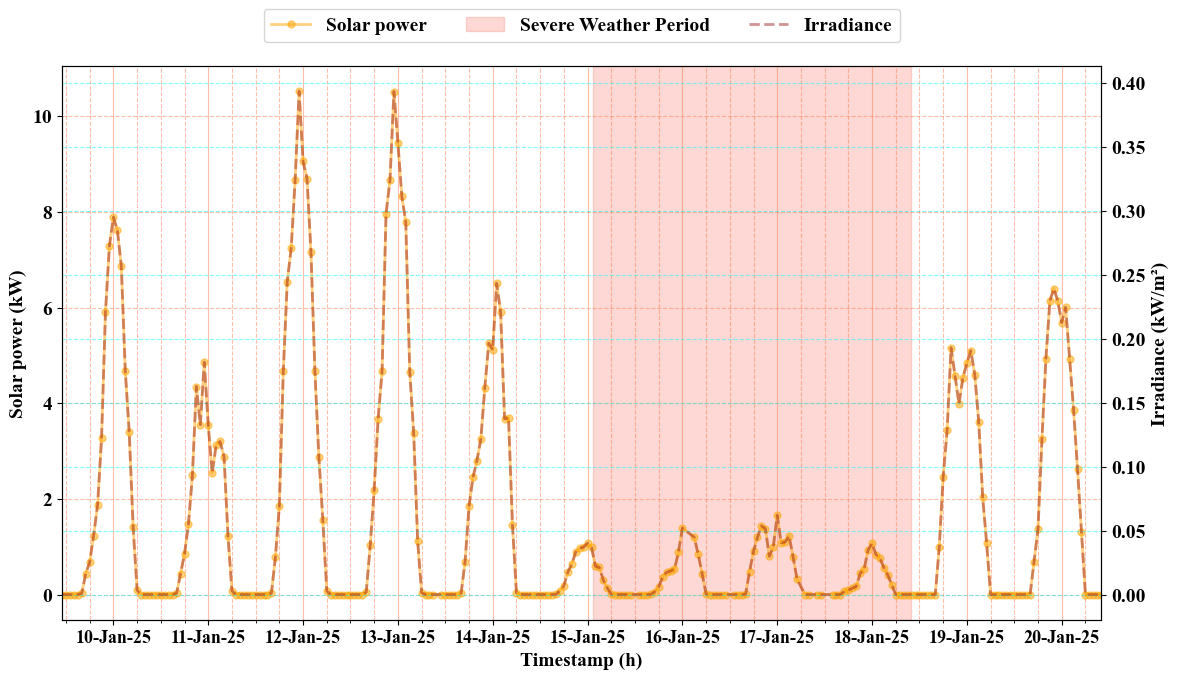

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set font globally
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
plt.rcParams["font.weight"] = "bold"

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 7))

# 1. Plot: Solar power (PV_kW) on the primary y‐axis (ax1) with a bold,
ax1.plot(
    df['Timestamp'],
    df['PV_kW'],
    color='orange',
    linewidth=2,
    marker='o',
    markersize=5,
    alpha=0.5,
    label='Solar power'
)

# Create a secondary y‐axis sharing the same x‐axis
ax2 = ax1.twinx()

# 2. Plot: Irradiance (kW/m²) on the secondary y‐axis (ax2) with a distinct,
ax2.plot(
    df['Timestamp'],
    df['Irradiance_kW/m2'],
    color='brown',
    linewidth=2,
    linestyle='--',
    # marker='o',
    markersize=3,
    alpha=0.5,
    label='Irradiance'
)

# Axis labels
ax1.set_xlabel('Timestamp (h)', fontweight='bold')
ax1.set_ylabel('Solar power (kW)', fontweight='bold')
ax2.set_ylabel('Irradiance (kW/m²)', fontweight='bold')

# 1. Major ticks at 12:00 each day (so "10 Jan 2025" appears at midday)
ax1.xaxis.set_major_locator(mdates.HourLocator(byhour=12+1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))

# 2. Minor ticks = every 6 hours
ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=6))

# 3. Vertical grid lines at every 6h (minor ticks)
ax1.grid(which='minor', linestyle='--', color='coral', alpha=0.5)

# 3a. Horizontal grid lines at each y‐major tick
ax1.grid(which='major', axis='y', linestyle='--', color='coral', alpha=0.5)

ax2.grid(which='major', axis='y', linestyle='--', color='cyan', alpha=0.5)

# 4. Ensure no grid at x‐major ticks
ax1.grid(which='major', axis='x', color='coral', alpha=0.5, visible=True)

# 5. Fix x‐axis range: Jan 10 00:00 → Jan 20 23:00
start = pd.Timestamp("2025-01-10 00:00")
end   = pd.Timestamp("2025-01-20 23:00")
ax1.set_xlim(start, end)

# 6. Keep x‐axis labels horizontal & set font size
ax1.tick_params(axis='x', rotation=0, labelsize=13)

# Remove or comment out this line so labels stay horizontal:
# fig.autofmt_xdate()

# Shade 15–19 Jan as severe weather
ax1.axvspan(
    pd.Timestamp("2025-01-15 14:20"),
    pd.Timestamp("2025-01-18 22:59"),
    color='salmon',
    alpha=0.3,
    label='Severe Weather Period'
)

# Merge legends from both axes + shaded patch
lines, labels   = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines + lines2,
    labels + labels2,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.12),
    ncol=3,
    frameon=True
)

plt.tight_layout()
plt.savefig(
    "Figures/Wollongong_SolarPower_10_20_Jan_2025.png",
    dpi=600,
    bbox_inches='tight'
)
# plt.show()


In [9]:
df

,Timestamp,Temperature_C,Wind_km_h,Humidity_%,Precipitation_%,Irradiance_kW/m2,PV_kW
0,2025-01-10 00:00:00,21,9,92,14.98,0.0,0.0
1,2025-01-10 01:00:00,21,9,93,15.87,0.0,0.0
2,2025-01-10 02:00:00,20,11,95,17.66,0.0,0.0
3,2025-01-10 03:00:00,20,7,95,19.06,0.0,0.0
4,2025-01-10 04:00:00,20,13,96,19.84,0.0,0.0
...,...,...,...,...,...,...,...
250,2025-01-20 19:00:00,21,11,62,0.00,0.0,0.0
251,2025-01-20 20:00:00,20,9,65,1.96,0.0,0.0
252,2025-01-20 21:00:00,20,0,67,4.21,0.0,0.0
253,2025-01-20 22:00:00,18,0,73,6.73,0.0,0.0


In [10]:
# Step 6: Save the updated DataFrame (keeping only desired columns)
output_cols = [
    'Timestamp',
    'Irradiance_kW/m2',
    'PV_kW'
]
df = df[output_cols].copy()
df[output_cols].to_csv("Data/Test/PowerGeneration_Solar__10_20_Jan_2025.csv", index=False)
df

,Timestamp,Irradiance_kW/m2,PV_kW
0,2025-01-10 00:00:00,0.0,0.0
1,2025-01-10 01:00:00,0.0,0.0
2,2025-01-10 02:00:00,0.0,0.0
3,2025-01-10 03:00:00,0.0,0.0
4,2025-01-10 04:00:00,0.0,0.0
...,...,...,...
250,2025-01-20 19:00:00,0.0,0.0
251,2025-01-20 20:00:00,0.0,0.0
252,2025-01-20 21:00:00,0.0,0.0
253,2025-01-20 22:00:00,0.0,0.0
